In [2]:
from bias_tree import BiasDetectionTree, get_metric_bias_tree_for_model
from data_preparation.movielens_100k import MovieLens100KData
from recommender import fit_recommendation_model
from sklearn.model_selection import train_test_split


### Prepare training data

In [3]:
data = MovieLens100KData(data_path='data/ml-100k')
ratings_with_metadata = data.get_ratings_with_metadata()

attributes = {attr: 'categorical' for attr in data.attributes_categorical}
attributes.update({attr: 'continuous' for attr in data.attributes_continuous})
ratings_with_metadata.head()

user_ids = ratings_with_metadata["user"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings_with_metadata["item"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings_with_metadata["user_id"] = ratings_with_metadata["user"].map(user2user_encoded)
ratings_with_metadata["movie_id"] = ratings_with_metadata["item"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_items = len(movie_encoded2movie)

X_train, X_test = train_test_split(ratings_with_metadata, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=1) 

### Train MF recommendation model

Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/sample - loss: 0.6601 - val_loss: 0.6425
Epoch 2/20
60000/60000 [==============================] - 4s 67us/sample - loss: 0.6393 - val_loss: 0.6608
Epoch 3/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.6352 - val_loss: 0.6292
Epoch 4/20
60000/60000 [==============================] - 4s 73us/sample - loss: 0.6356 - val_loss: 0.6492
Epoch 5/20
60000/60000 [==============================] - 4s 72us/sample - loss: 0.6440 - val_loss: 0.6292
Epoch 6/20
60000/60000 [==============================] - 4s 72us/sample - loss: 0.6477 - val_loss: 0.6563
Epoch 7/20
60000/60000 [==============================] - 3s 53us/sample - loss: 0.6617 - val_loss: 0.6375
Epoch 8/20
60000/60000 [==============================] - 4s 61us/sample - loss: 0.6664 - val_loss: 0.6742
Epoch 9/20
60000/60000 [==============================] - 4s 67us/sample - loss: 0.6848 - val_

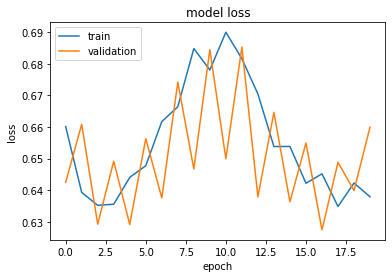

In [57]:
model = fit_recommendation_model(X_train, X_val, num_users=num_users, num_items=num_items, epochs=20, embedding_size=100)

### Analyze bias for the recommendation model

Train data bias

root=[]: 0.23
├── year_bucketized=['<missing>', 'low']: 0.22
├── year_bucketized=['high']: 0.24
└── year_bucketized=['medium']: 0.23
    ├── age_bucketized=['high', 'medium']: 0.23
    └── age_bucketized=['low']: 0.23



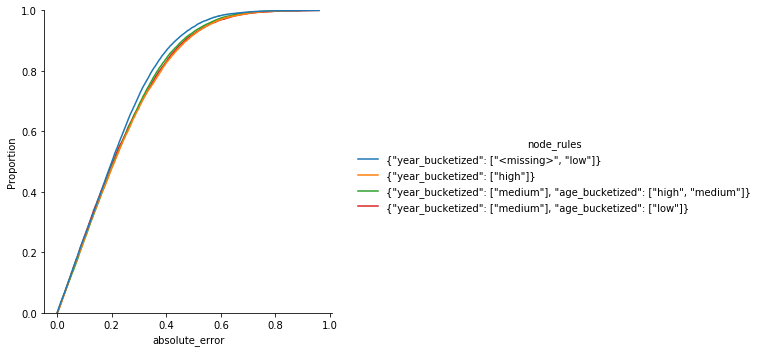

In [46]:
bias_tree_train = get_metric_bias_tree_for_model(model, X_train, attributes, 
                                                 metric_name='absolute_error', min_child_node_size=10000,)

In [47]:
bias_tree_train.max_metric_node

'{"year_bucketized": ["high"]}'

In [48]:
bias_tree_train.leaf_metrics

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""<missing>"", ""low""]}",20054.0,0.222099,0.152768,0.000025,0.098870,0.200350,0.316389,0.960509
"{""year_bucketized"": [""medium""], ""age_bucketized"": [""high"", ""medium""]}",18050.0,0.233433,0.161143,0.000022,0.103178,0.208631,0.335578,0.893876
"{""year_bucketized"": [""medium""], ""age_bucketized"": [""low""]}",10825.0,0.234484,0.167553,0.000028,0.098573,0.204818,0.341645,0.960784
"{""year_bucketized"": [""high""]}",11067.0,0.237635,0.166973,0.000093,0.102475,0.210775,0.344750,0.871014


In [49]:
X_train_filtered = bias_tree_train.get_filtered_df(bias_tree_train.max_metric_node,  X_train)
X_val_filtered = bias_tree_train.get_filtered_df(bias_tree_train.max_metric_node,  X_val)

Train on 11067 samples, validate on 3711 samples
Epoch 1/20
11067/11067 [==============================] - 1s 59us/sample - loss: 0.6591 - val_loss: 0.6629
Epoch 2/20
11067/11067 [==============================] - 1s 59us/sample - loss: 0.6967 - val_loss: 0.6556
Epoch 3/20
11067/11067 [==============================] - 1s 57us/sample - loss: 0.7593 - val_loss: 0.6410
Epoch 4/20
11067/11067 [==============================] - 1s 57us/sample - loss: 0.7222 - val_loss: 0.6302
Epoch 5/20
11067/11067 [==============================] - 1s 58us/sample - loss: 0.6366 - val_loss: 0.6285
Epoch 6/20
11067/11067 [==============================] - 1s 87us/sample - loss: 0.6168 - val_loss: 0.6284
Epoch 7/20
11067/11067 [==============================] - 1s 59us/sample - loss: 0.6110 - val_loss: 0.6280
Epoch 8/20
11067/11067 [==============================] - 1s 58us/sample - loss: 0.6118 - val_loss: 0.6286
Epoch 9/20
11067/11067 [==============================] - 1s 57us/sample - loss: 0.6105 - val_l

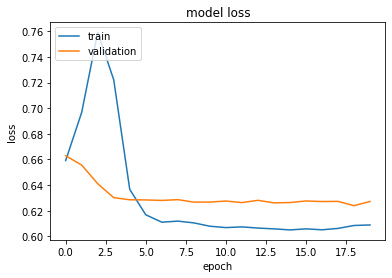

In [50]:
model_bias = fit_recommendation_model( X_train_filtered, X_val_filtered, model=model,
                                      num_users=num_users, num_items=num_items, epochs=20)

root=[]: 0.21
├── year_bucketized=['<missing>', 'low']: 0.2
└── year_bucketized=['high', 'medium']: 0.21
    ├── gender=['F']: 0.22
    └── gender=['M']: 0.21
        ├── user activity_bucketized=['high', 'medium']: 0.21
        └── user activity_bucketized=['low']: 0.21



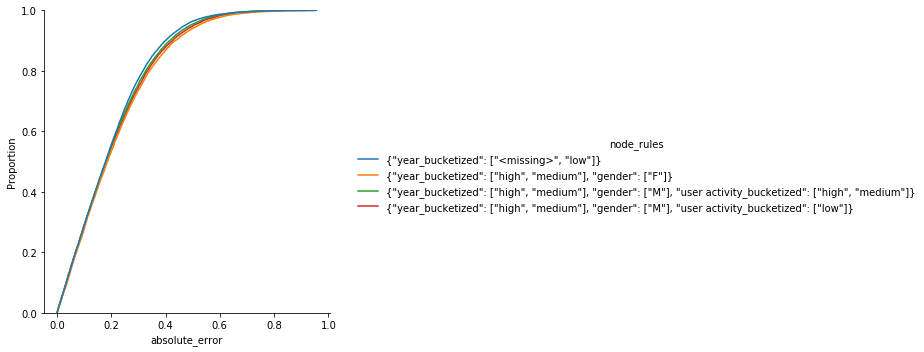

In [54]:
bias_tree_train_retrained = get_metric_bias_tree_for_model(model_bias, X_train, attributes, 
                                                 metric_name='absolute_error', min_child_node_size=10000,)

In [52]:
bias_tree_train_retrained.leaf_metrics

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""<missing>"", ""low""]}",20054.0,0.201135,0.144128,0.000021,0.086177,0.178763,0.285910,0.956603
"{""year_bucketized"": [""high"", ""medium""], ""gender"": [""M""], ""user activity_bucketized"": [""high"", ""medium""]}",18839.0,0.205697,0.148832,0.000008,0.086541,0.180500,0.296664,0.917232
"{""year_bucketized"": [""high"", ""medium""], ""gender"": [""M""], ""user activity_bucketized"": [""low""]}",10425.0,0.208662,0.152910,0.000052,0.085674,0.180927,0.301931,0.837136
"{""year_bucketized"": [""high"", ""medium""], ""gender"": [""F""]}",10678.0,0.215212,0.158127,0.000010,0.090887,0.185855,0.309052,0.948912


In [56]:
bias_tree_train.get_filtered_df(bias_tree_train.max_metric_node,  X_train)['absolute_error'].mean()

0.20562855785558937

Validation data bias

root=[]: 0.2
├── year_bucketized=['<missing>', 'low']: 0.19
│   ├── gender=['F']: 0.2
│   └── gender=['M']: 0.18
│       ├── user activity_bucketized=['high', 'low']: 0.19
│       └── user activity_bucketized=['medium']: 0.18
└── year_bucketized=['high', 'medium']: 0.2
    ├── gender=['F']: 0.21
    └── gender=['M']: 0.2
        ├── item popularity_bucketized=['high']: 0.2
        └── item popularity_bucketized=['low', 'medium']: 0.2



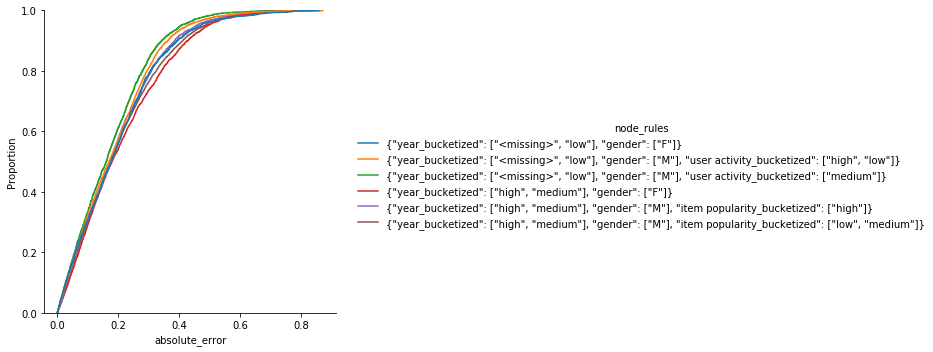

In [35]:
bias_tree_val = get_metric_bias_tree_for_model(model, X_val, attributes, 
                                                 metric_name='absolute_error', min_child_node_size=1000,)

In [13]:
bias_tree_val.max_metric_node

'{"year_bucketized": ["high"], "item popularity_bucketized": ["low", "medium"], "user activity_bucketized": ["low"]}'

In [14]:
bias_tree_val.min_metric_node

'{"year_bucketized": ["<missing>", "low"], "gender": ["M"]}'

In [15]:
bias_tree_val.leaf_metrics

,count,mean,std,min,25%,50%,75%,max
node_rules,,,,,,,,
"{""year_bucketized"": [""<missing>"", ""low""], ""gender"": [""M""]}",5060.0,0.191438,0.132532,0.000025,0.082989,0.172120,0.282322,0.814976
"{""year_bucketized"": [""medium""], ""gender"": [""M""], ""Drama"": [1]}",2892.0,0.197892,0.138392,0.000128,0.088495,0.172123,0.288853,0.814089
"{""year_bucketized"": [""medium""], ""gender"": [""M""], ""Drama"": [0]}",4187.0,0.200141,0.145451,0.000053,0.078780,0.174229,0.290176,0.744337
"{""year_bucketized"": [""high""], ""item popularity_bucketized"": [""high""]}",1230.0,0.200859,0.138678,0.000621,0.085106,0.185481,0.289859,0.714079
"{""year_bucketized"": [""<missing>"", ""low""], ""gender"": [""F""]}",1629.0,0.205068,0.144542,0.000146,0.085652,0.184999,0.297002,0.823361
"{""year_bucketized"": [""high""], ""item popularity_bucketized"": [""low"", ""medium""], ""user activity_bucketized"": [""high"", ""medium""]}",1140.0,0.207827,0.147812,0.000062,0.090770,0.186500,0.305586,0.699705
"{""year_bucketized"": [""medium""], ""gender"": [""F""]}",2516.0,0.217746,0.152151,0.000124,0.090482,0.190278,0.324321,0.784174
"{""year_bucketized"": [""high""], ""item popularity_bucketized"": [""low"", ""medium""], ""user activity_bucketized"": [""low""]}",1341.0,0.226076,0.159827,0.000026,0.092720,0.199005,0.346415,0.802645
